In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Cài đặt 
!pip install xgboost
!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1
import warnings
warnings.simplefilter('ignore', FutureWarning)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


In [2]:
import pandas as pd

df01 = pd.read_csv('/kaggle/input/clean-aws-month/final_data/filled_data_april.csv')
df02 = pd.read_csv('/kaggle/input/clean-aws-month/final_data/filled_data_october.csv')

# Ghép 2 file lại với nhau
data_filled = pd.concat([df01, df02], ignore_index=True)

# 1. Xử lý dữ liệu bị thiếu

In [3]:
# df_cleaned = data.copy()
# df_cleaned = df_cleaned.drop(columns=['B04B', 'B05B', 'B06B', 'VSB', 'CIN'])

# df_cleaned = df_cleaned[~((df_cleaned['AWS'] == -np.inf) | (df_cleaned['AWS'].isnull()))]
# df_cleaned = df_cleaned[~((df_cleaned['SLHF'] == 9999) | (df_cleaned['SSHF'] == 9999))]

In [4]:
# data_filled = df_cleaned.fillna(df_cleaned.median(numeric_only=True))

# 2. Chia train test

In [5]:
def split_data_by_multiple_ranges(df, train_ranges):
    train_mask = False
    for start, end in train_ranges:
        train_mask |= (df['datetime'] >= start) & (df['datetime'] < end)
    train_df = df[train_mask]
    test_df = df[~train_mask]
    return train_df, test_df

def convert_rain_label(df):
    df['AWS'] = df['AWS'].apply(lambda x: 1 if x > 0 else 0)
    return df

# Gắn nhãn
df_all1 = convert_rain_label(data_filled)

# Chuyển datetime nếu chưa
df_all1['datetime'] = pd.to_datetime(df_all1['datetime'])

# Chọn các khoảng train: tháng 4/2019, 10/2019, 4/2020
train_ranges = [
    ("2019-04-01", "2019-04-30"),
    ("2019-10-01", "2019-10-31"),
    ("2020-04-01", "2020-04-30"),
]

# Tách train/test theo mốc trên
train_df, test_df = split_data_by_multiple_ranges(df_all1, train_ranges)

# Giữ lại chỉ test tháng 10/2020
test_df = test_df[
    (test_df['datetime'] >= "2020-10-01") & (test_df['datetime'] <= "2020-10-31")
]

# Kết quả
print(f"Train set: {train_df.shape}")
print(f"Test set (October 2020): {test_df.shape}")

Train set: (428242, 33)
Test set (October 2020): (207094, 33)


In [6]:
X_train = train_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_train = train_df['AWS']

X_test = test_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_test = test_df['AWS']

# 3. Chuẩn hóa

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# 4. Chọn feature

In [8]:
top_features = ['B14B', 'I2B', 'TCLW', 'R500', 'R850', 'CAPE', 'U850', 'B10B', 'PEV', 'SLOR', 'R250', 'KX', 'V250', 'U250', 'TCWV']

In [9]:
# X_train_selected = X_train_scaled[top_features]
# X_test_selected = X_test_scaled[top_features]

In [10]:
#Performance evaluation
def print_scores(y_true, y_pred):
  print(classification_report(y_true, y_pred))

# 5. Thêm class weight

In [11]:
from catboost import CatBoostClassifier

# Khởi tạo CatBoost model với xử lý mất cân bằng
cat_model = CatBoostClassifier()

# Train
cat_model.fit(X_train, y_train)

# Predict
y_pred = cat_model.predict(X_test)

print_scores(y_test, y_pred)

Learning rate set to 0.136983
0:	learn: 0.5198129	total: 113ms	remaining: 1m 53s
1:	learn: 0.4161434	total: 165ms	remaining: 1m 22s
2:	learn: 0.3489452	total: 215ms	remaining: 1m 11s
3:	learn: 0.3113713	total: 265ms	remaining: 1m 5s
4:	learn: 0.2816391	total: 316ms	remaining: 1m 2s
5:	learn: 0.2615813	total: 369ms	remaining: 1m 1s
6:	learn: 0.2461991	total: 419ms	remaining: 59.5s
7:	learn: 0.2354892	total: 474ms	remaining: 58.8s
8:	learn: 0.2280133	total: 529ms	remaining: 58.3s
9:	learn: 0.2230871	total: 580ms	remaining: 57.4s
10:	learn: 0.2186294	total: 634ms	remaining: 57s
11:	learn: 0.2156588	total: 690ms	remaining: 56.8s
12:	learn: 0.2122695	total: 748ms	remaining: 56.8s
13:	learn: 0.2108051	total: 798ms	remaining: 56.2s
14:	learn: 0.2089366	total: 851ms	remaining: 55.9s
15:	learn: 0.2081817	total: 896ms	remaining: 55.1s
16:	learn: 0.2067229	total: 951ms	remaining: 55s
17:	learn: 0.2055117	total: 1s	remaining: 54.6s
18:	learn: 0.2046388	total: 1.05s	remaining: 54.4s
19:	learn: 0.20

In [12]:
from catboost import CatBoostClassifier

# Khởi tạo CatBoost model với xử lý mất cân bằng
cat_model = CatBoostClassifier()

# Train
cat_model.fit(X_train_scaled, y_train)

# Predict
y_pred = cat_model.predict(X_test_scaled)

print_scores(y_test, y_pred)

Learning rate set to 0.136983
0:	learn: 0.5198129	total: 55.5ms	remaining: 55.4s
1:	learn: 0.4161434	total: 106ms	remaining: 53s
2:	learn: 0.3489452	total: 156ms	remaining: 51.9s
3:	learn: 0.3113713	total: 209ms	remaining: 52s
4:	learn: 0.2816391	total: 260ms	remaining: 51.8s
5:	learn: 0.2615813	total: 312ms	remaining: 51.7s
6:	learn: 0.2461992	total: 363ms	remaining: 51.5s
7:	learn: 0.2354893	total: 420ms	remaining: 52.1s
8:	learn: 0.2280133	total: 474ms	remaining: 52.2s
9:	learn: 0.2230871	total: 525ms	remaining: 51.9s
10:	learn: 0.2186295	total: 581ms	remaining: 52.2s
11:	learn: 0.2156588	total: 636ms	remaining: 52.4s
12:	learn: 0.2121366	total: 693ms	remaining: 52.6s
13:	learn: 0.2107045	total: 741ms	remaining: 52.2s
14:	learn: 0.2086718	total: 794ms	remaining: 52.2s
15:	learn: 0.2073422	total: 849ms	remaining: 52.2s
16:	learn: 0.2066049	total: 894ms	remaining: 51.7s
17:	learn: 0.2049944	total: 945ms	remaining: 51.5s
18:	learn: 0.2042240	total: 997ms	remaining: 51.5s
19:	learn: 0.2

In [13]:
from catboost import CatBoostClassifier

# Khởi tạo CatBoost model với xử lý mất cân bằng
cat_model = CatBoostClassifier()

# Train
cat_model.fit(X_train_scaled[top_features], y_train)

# Predict
y_pred = cat_model.predict(X_test_scaled[top_features])

print_scores(y_test, y_pred)

Learning rate set to 0.136983
0:	learn: 0.5256730	total: 41.9ms	remaining: 41.8s
1:	learn: 0.4215933	total: 85.2ms	remaining: 42.5s
2:	learn: 0.3569475	total: 127ms	remaining: 42.1s
3:	learn: 0.3121148	total: 169ms	remaining: 42.2s
4:	learn: 0.2814666	total: 213ms	remaining: 42.3s
5:	learn: 0.2600845	total: 257ms	remaining: 42.5s
6:	learn: 0.2461371	total: 300ms	remaining: 42.6s
7:	learn: 0.2372788	total: 341ms	remaining: 42.2s
8:	learn: 0.2296856	total: 380ms	remaining: 41.8s
9:	learn: 0.2234373	total: 423ms	remaining: 41.8s
10:	learn: 0.2199695	total: 461ms	remaining: 41.5s
11:	learn: 0.2165366	total: 504ms	remaining: 41.5s
12:	learn: 0.2147320	total: 547ms	remaining: 41.5s
13:	learn: 0.2123073	total: 589ms	remaining: 41.5s
14:	learn: 0.2109574	total: 633ms	remaining: 41.5s
15:	learn: 0.2093521	total: 678ms	remaining: 41.7s
16:	learn: 0.2080689	total: 721ms	remaining: 41.7s
17:	learn: 0.2070112	total: 764ms	remaining: 41.7s
18:	learn: 0.2057668	total: 808ms	remaining: 41.7s
19:	learn

=> Scale cao hơn

=> Không chọn đặc trưng cao hơn

In [14]:
from catboost import CatBoostClassifier

# Khởi tạo CatBoost model với xử lý mất cân bằng
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    scale_pos_weight=11.32,     # tương đương XGBoost
    random_seed=42,
    verbose=0               # tắt output training
)

# Train
cat_model.fit(X_train, y_train)

# Predict
y_pred = cat_model.predict(X_test)

print_scores(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.98      0.58      0.73    159566
           1       0.40      0.96      0.57     47528

    accuracy                           0.66    207094
   macro avg       0.69      0.77      0.65    207094
weighted avg       0.85      0.66      0.69    207094



=> Recall cao, f1 và precision không cao lắm

In [15]:
from catboost import CatBoostClassifier

# Khởi tạo CatBoost model với xử lý mất cân bằng
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    scale_pos_weight=11.32,     # tương đương XGBoost
    random_seed=42,
    verbose=0               # tắt output training
)

# Train
cat_model.fit(X_train_scaled, y_train)

# Predict
y_pred = cat_model.predict(X_test_scaled)

print_scores(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.98      0.58      0.73    159566
           1       0.40      0.96      0.57     47528

    accuracy                           0.67    207094
   macro avg       0.69      0.77      0.65    207094
weighted avg       0.85      0.67      0.69    207094



In [16]:
from catboost import CatBoostClassifier

# Khởi tạo CatBoost model với xử lý mất cân bằng
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    scale_pos_weight=11.32,     # tương đương XGBoost
    random_seed=42,
    verbose=0               # tắt output training
)

# Train
cat_model.fit(X_train_scaled[top_features], y_train)

# Predict
y_pred = cat_model.predict(X_test_scaled[top_features])

print_scores(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.98      0.54      0.70    159566
           1       0.38      0.97      0.55     47528

    accuracy                           0.64    207094
   macro avg       0.68      0.75      0.62    207094
weighted avg       0.85      0.64      0.66    207094



=> Chứng tỏ với bộ tham số khác, selected ngang ngửa với scale, thấp hơn chút.

=> **train = train_scaled > selected**

CatBoost không cần chuẩn hóa.

**Nhận xét về CatBoost:**

| Thử nghiệm            | Precision lớp 1 | Recall lớp 1 | F1 lớp 1 | Nhận xét chính |
|------------------------|------------------|---------------|------------|----------------|
| CatBoost mặc định       | 0.66             | 0.47          | 0.55       | Thiên lệch lớp 0 |
| + weight 3.36          | 0.53             | 0.88          | 0.66       | Phát hiện mưa tốt hơn |
| + chuẩn hóa            | 0.52             | 0.88          | 0.65       | Không cải thiện nhiều |
| + giảm đặc trưng       | 0.51             | 0.86          | 0.64       | Hiệu quả giảm nhẹ |

* CatBoost không cần chuẩn hóa.

=> Giải pháp:
* Sử dụng Voting hoặc Stacking:
Nếu CatBoost nghiêng về phát hiện lớp 1 thì kết hợp với mô hình có xu hướng khác (như RF nghiêng về lớp 0) để có Voting hoặc Stacking ổn định hơn.

Best threshold: 0.8300000000000001, F1: 0.6805327494982668


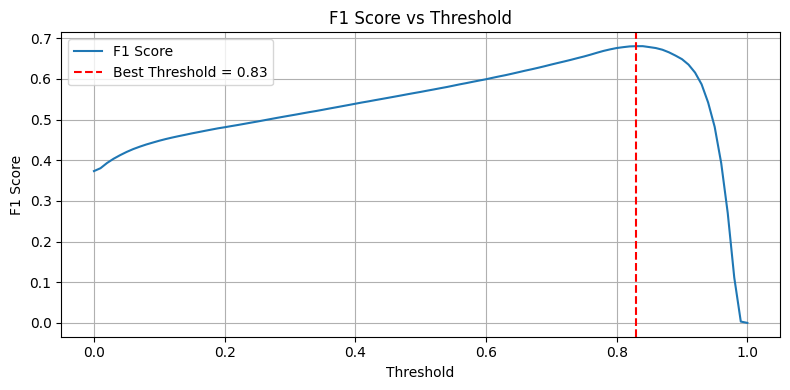

In [17]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Huấn luyện mô hình với scale_pos_weight
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    scale_pos_weight=11.32,
    random_seed=42,
    verbose=0
)

cat_model.fit(X_train, y_train)

# Dự đoán xác suất
y_probs = cat_model.predict_proba(X_test)[:, 1]

import numpy as np
import matplotlib.pyplot as plt

thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_t = (y_probs >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_t))

# Tìm ngưỡng tốt nhất
best_thresh = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"Best threshold: {best_thresh}, F1: {best_f1}")

# Vẽ biểu đồ
plt.figure(figsize=(8, 4))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.axvline(best_thresh, color='r', linestyle='--', label=f'Best Threshold = {best_thresh:.2f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Tuning CatBoost với Optuna**

In [18]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

THRESHOLD = best_thresh
SCALE_POS_WEIGHT = 11.32

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'scale_pos_weight': SCALE_POS_WEIGHT,
        'random_seed': 42,
        'verbose': 0
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)

    # Dự đoán xác suất và áp dụng threshold
    y_probs = model.predict_proba(X_test)[:, 1]
    y_pred = (y_probs >= THRESHOLD).astype(int)

    # Đánh giá bằng F1-score cho lớp mất cân bằng
    score = f1_score(y_test, y_pred)
    return score

# Tạo và chạy study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# In kết quả tốt nhất
print("Best trial:")
print(study.best_trial)
print("Best F1 Score:", study.best_value)
print("Best hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")

# Huấn luyện lại với tham số tốt nhất
best_params = study.best_trial.params
best_params.update({
    'scale_pos_weight': SCALE_POS_WEIGHT,
    'random_seed': 42,
    'verbose': 0
})

best_model = CatBoostClassifier(**best_params)
best_model.fit(X_train, y_train)

# Dự đoán với threshold 
y_probs = best_model.predict_proba(X_test)[:, 1]
y_pred_thresh = (y_probs >= THRESHOLD).astype(int)

# In kết quả
from sklearn.metrics import classification_report
print(f"\nClassification report with threshold = {THRESHOLD}:")
print(classification_report(y_test, y_pred_thresh))

[I 2025-05-04 04:03:56,233] A new study created in memory with name: no-name-36fe6148-15a8-4499-b87e-2143a63df49b
[I 2025-05-04 04:04:13,336] Trial 0 finished with value: 0.604804233498431 and parameters: {'iterations': 265, 'depth': 7, 'learning_rate': 0.27823489543295055}. Best is trial 0 with value: 0.604804233498431.
[I 2025-05-04 04:04:31,615] Trial 1 finished with value: 0.6683204154319856 and parameters: {'iterations': 392, 'depth': 4, 'learning_rate': 0.2794889335845733}. Best is trial 1 with value: 0.6683204154319856.
[I 2025-05-04 04:04:59,628] Trial 2 finished with value: 0.5926256216772423 and parameters: {'iterations': 370, 'depth': 8, 'learning_rate': 0.14878700756448038}. Best is trial 1 with value: 0.6683204154319856.
[I 2025-05-04 04:05:05,312] Trial 3 finished with value: 0.6681286811435937 and parameters: {'iterations': 118, 'depth': 4, 'learning_rate': 0.20084524813016866}. Best is trial 1 with value: 0.6683204154319856.
[I 2025-05-04 04:05:20,967] Trial 4 finished 

Best trial:
FrozenTrial(number=12, state=1, values=[0.6865322174966846], datetime_start=datetime.datetime(2025, 5, 4, 4, 8, 30, 931453), datetime_complete=datetime.datetime(2025, 5, 4, 4, 8, 52, 655627), params={'iterations': 414, 'depth': 5, 'learning_rate': 0.07399747263500986}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=500, log=False, low=100, step=1), 'depth': IntDistribution(high=10, log=False, low=4, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None)}, trial_id=12, value=None)
Best F1 Score: 0.6865322174966846
Best hyperparameters:
iterations: 414
depth: 5
learning_rate: 0.07399747263500986

Classification report with threshold = 0.8300000000000001:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89    159566
           1       0.61      0.79      0.69     47528

    accuracy                           0.83    207094
   macro avg       

In [19]:
# from sklearn.metrics import (
#     accuracy_score, precision_score, recall_score,
#     f1_score, classification_report, confusion_matrix
# )
# # Tạo mô hình với tham số đã tối ưu
# catboost_model = CatBoostClassifier(
#     iterations=292,
#     depth=5,
#     learning_rate=0.25030502714970054,
#     scale_pos_weight=11.32,
#     random_seed=42,
#     verbose=0
# )

# # Huấn luyện mô hình
# catboost_model.fit(X_train, y_train)

# # Dự đoán xác suất
# y_probs = catboost_model.predict_proba(X_test)[:, 1]

# # Áp dụng threshold
# THRESHOLD = 0.83
# y_pred = (y_probs >= THRESHOLD).astype(int)

# # Đánh giá mô hình
# acc = accuracy_score(y_test, y_pred)
# prec = precision_score(y_test, y_pred)
# rec = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

# print("Threshold:", THRESHOLD)
# print("Accuracy :", acc)
# print("Precision:", prec)
# print("Recall   :", rec)
# print("F1 Score :", f1)
# print("\nClassification Report:\n", classification_report(y_test, y_pred))

# # Confusion Matrix
# cm = confusion_matrix(y_test, y_pred)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title(f'Confusion Matrix - CatBoost (Threshold = {THRESHOLD})')
# plt.show()

In [20]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Huấn luyện mô hình với scale_pos_weight
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    scale_pos_weight=11.32,
    random_seed=42,
    verbose=0
)

cat_model.fit(X_train_scaled[top_features], y_train)

# Dự đoán xác suất
y_probs = cat_model.predict_proba(X_test_scaled[top_features])[:, 1]


y_pred = cat_model.predict(X_test_scaled[top_features])
print_scores( y_test, y_pred)

y_probs = cat_model.predict_proba(X_test_scaled[top_features])[:,1]

best_thresh = 0.0
best_f1 = 0.0
for t in np.arange(0.1, 0.9, 0.05):
    y_pred = (y_probs >= t).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"Best threshold: {best_thresh}, F1: {best_f1}")

              precision    recall  f1-score   support

           0       0.98      0.54      0.70    159566
           1       0.38      0.97      0.55     47528

    accuracy                           0.64    207094
   macro avg       0.68      0.75      0.62    207094
weighted avg       0.85      0.64      0.66    207094

Best threshold: 0.8500000000000002, F1: 0.6719979457456761


In [21]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

THRESHOLD = best_thresh
SCALE_POS_WEIGHT = 11.32

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'scale_pos_weight': SCALE_POS_WEIGHT,
        'random_seed': 42,
        'verbose': 0
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train_scaled[top_features], y_train)

    # Dự đoán xác suất và áp dụng threshold
    y_probs = model.predict_proba(X_test_scaled[top_features])[:, 1]
    y_pred = (y_probs >= THRESHOLD).astype(int)

    # Đánh giá bằng F1-score cho lớp mất cân bằng
    score = f1_score(y_test, y_pred)
    return score

# Tạo và chạy study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# In kết quả tốt nhất
print("Best trial:")
print(study.best_trial)
print("Best F1 Score:", study.best_value)
print("Best hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")

# Huấn luyện lại với tham số tốt nhất
best_params = study.best_trial.params
best_params.update({
    'scale_pos_weight': SCALE_POS_WEIGHT,
    'random_seed': 42,
    'verbose': 0
})

best_model = CatBoostClassifier(**best_params)
best_model.fit(X_train_scaled[top_features], y_train)

# Dự đoán với threshold 
y_probs = best_model.predict_proba(X_test_scaled[top_features])[:, 1]
y_pred_thresh = (y_probs >= THRESHOLD).astype(int)

# In kết quả
from sklearn.metrics import classification_report
print(f"\nClassification report with threshold = {THRESHOLD}:")
print(classification_report(y_test, y_pred_thresh))

[I 2025-05-04 04:23:55,889] A new study created in memory with name: no-name-62a56226-e686-44a0-865a-5d31f31d50a1
[I 2025-05-04 04:24:07,335] Trial 0 finished with value: 0.6592654234595453 and parameters: {'iterations': 262, 'depth': 5, 'learning_rate': 0.17804541207016272}. Best is trial 0 with value: 0.6592654234595453.
[I 2025-05-04 04:24:11,027] Trial 1 finished with value: 0.6606837211453949 and parameters: {'iterations': 112, 'depth': 5, 'learning_rate': 0.17622367139444328}. Best is trial 1 with value: 0.6606837211453949.
[I 2025-05-04 04:24:23,481] Trial 2 finished with value: 0.4882515250126826 and parameters: {'iterations': 208, 'depth': 8, 'learning_rate': 0.2822827707554568}. Best is trial 1 with value: 0.6606837211453949.
[I 2025-05-04 04:24:35,782] Trial 3 finished with value: 0.6700913689659228 and parameters: {'iterations': 321, 'depth': 4, 'learning_rate': 0.23918467363675094}. Best is trial 3 with value: 0.6700913689659228.
[I 2025-05-04 04:25:01,202] Trial 4 finishe

Best trial:
FrozenTrial(number=38, state=1, values=[0.6808048570915993], datetime_start=datetime.datetime(2025, 5, 4, 4, 32, 35, 424524), datetime_complete=datetime.datetime(2025, 5, 4, 4, 32, 49, 987885), params={'iterations': 269, 'depth': 7, 'learning_rate': 0.06339575440641976}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=500, log=False, low=100, step=1), 'depth': IntDistribution(high=10, log=False, low=4, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None)}, trial_id=38, value=None)
Best F1 Score: 0.6808048570915993
Best hyperparameters:
iterations: 269
depth: 7
learning_rate: 0.06339575440641976

Classification report with threshold = 0.8500000000000002:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89    159566
           1       0.62      0.76      0.68     47528

    accuracy                           0.84    207094
   macro avg     

In [22]:
# from sklearn.metrics import (
#     accuracy_score, precision_score, recall_score,
#     f1_score, classification_report, confusion_matrix
# )
# # Tạo mô hình với tham số đã tối ưu
# catboost_model = CatBoostClassifier(
#     iterations=336,
#     depth=6,
#     learning_rate=0.054827476508008136,
#     scale_pos_weight=11.32,
#     random_seed=42,
#     verbose=0
# )

# # Huấn luyện mô hình
# catboost_model.fit(X_train_scaled[top_features], y_train)

# # Dự đoán xác suất
# y_probs = catboost_model.predict_proba(X_test_scaled[top_features])[:, 1]

# # Áp dụng threshold
# THRESHOLD = 0.85
# y_pred = (y_probs >= THRESHOLD).astype(int)

# # Đánh giá mô hình
# acc = accuracy_score(y_test, y_pred)
# prec = precision_score(y_test, y_pred)
# rec = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

# print("Threshold:", THRESHOLD)
# print("Accuracy :", acc)
# print("Precision:", prec)
# print("Recall   :", rec)
# print("F1 Score :", f1)
# print("\nClassification Report:\n", classification_report(y_test, y_pred))

# # Confusion Matrix
# cm = confusion_matrix(y_test, y_pred)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title(f'Confusion Matrix - CatBoost (Threshold = {THRESHOLD})')
# plt.show()

In [23]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Huấn luyện mô hình với scale_pos_weight
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    scale_pos_weight=11.32,
    random_seed=42,
    verbose=0
)

cat_model.fit(X_train_scaled, y_train)

# Dự đoán xác suất
y_probs = cat_model.predict_proba(X_test_scaled)[:, 1]


y_pred = cat_model.predict(X_test_scaled)
print_scores( y_test, y_pred)

y_probs = cat_model.predict_proba(X_test_scaled)[:,1]

best_thresh = 0.0
best_f1 = 0.0
for t in np.arange(0.1, 0.9, 0.05):
    y_pred = (y_probs >= t).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"Best threshold: {best_thresh}, F1: {best_f1}")

              precision    recall  f1-score   support

           0       0.98      0.58      0.73    159566
           1       0.40      0.96      0.57     47528

    accuracy                           0.67    207094
   macro avg       0.69      0.77      0.65    207094
weighted avg       0.85      0.67      0.69    207094

Best threshold: 0.8000000000000002, F1: 0.6756195510400219


In [24]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

THRESHOLD = best_thresh
SCALE_POS_WEIGHT = 11.32

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'scale_pos_weight': SCALE_POS_WEIGHT,
        'random_seed': 42,
        'verbose': 0
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train_scaled, y_train)

    # Dự đoán xác suất và áp dụng threshold
    y_probs = model.predict_proba(X_test_scaled)[:, 1]
    y_pred = (y_probs >= THRESHOLD).astype(int)

    # Đánh giá bằng F1-score cho lớp mất cân bằng
    score = f1_score(y_test, y_pred)
    return score

# Tạo và chạy study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# In kết quả tốt nhất
print("Best trial:")
print(study.best_trial)
print("Best F1 Score:", study.best_value)
print("Best hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")

# Huấn luyện lại với tham số tốt nhất
best_params = study.best_trial.params
best_params.update({
    'scale_pos_weight': SCALE_POS_WEIGHT,
    'random_seed': 42,
    'verbose': 0
})

best_model = CatBoostClassifier(**best_params)
best_model.fit(X_train_scaled, y_train)

# Dự đoán với threshold 
y_probs = best_model.predict_proba(X_test_scaled)[:, 1]
y_pred_thresh = (y_probs >= THRESHOLD).astype(int)

# In kết quả
from sklearn.metrics import classification_report
print(f"\nClassification report with threshold = {THRESHOLD}:")
print(classification_report(y_test, y_pred_thresh))

[I 2025-05-04 04:35:45,438] A new study created in memory with name: no-name-a217b248-9bd9-427d-b39d-6a954c423242
[I 2025-05-04 04:36:19,268] Trial 0 finished with value: 0.5770140169470434 and parameters: {'iterations': 366, 'depth': 9, 'learning_rate': 0.27474291132761236}. Best is trial 0 with value: 0.5770140169470434.
[I 2025-05-04 04:36:39,512] Trial 1 finished with value: 0.6786742058566635 and parameters: {'iterations': 442, 'depth': 4, 'learning_rate': 0.14902402623969868}. Best is trial 1 with value: 0.6786742058566635.
[I 2025-05-04 04:37:07,413] Trial 2 finished with value: 0.6713177622741257 and parameters: {'iterations': 295, 'depth': 9, 'learning_rate': 0.02885217429052852}. Best is trial 1 with value: 0.6786742058566635.
[I 2025-05-04 04:38:14,794] Trial 3 finished with value: 0.6673627565158026 and parameters: {'iterations': 410, 'depth': 10, 'learning_rate': 0.05305104724193716}. Best is trial 1 with value: 0.6786742058566635.
[I 2025-05-04 04:38:59,870] Trial 4 finis

Best trial:
FrozenTrial(number=40, state=1, values=[0.684188079752639], datetime_start=datetime.datetime(2025, 5, 4, 4, 49, 41, 976448), datetime_complete=datetime.datetime(2025, 5, 4, 4, 50, 2, 513796), params={'iterations': 350, 'depth': 6, 'learning_rate': 0.07771638036697479}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=500, log=False, low=100, step=1), 'depth': IntDistribution(high=10, log=False, low=4, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None)}, trial_id=40, value=None)
Best F1 Score: 0.684188079752639
Best hyperparameters:
iterations: 350
depth: 6
learning_rate: 0.07771638036697479

Classification report with threshold = 0.8000000000000002:
              precision    recall  f1-score   support

           0       0.94      0.83      0.88    159566
           1       0.59      0.81      0.68     47528

    accuracy                           0.83    207094
   macro avg       0

In [25]:
# from sklearn.metrics import (
#     accuracy_score, precision_score, recall_score,
#     f1_score, classification_report, confusion_matrix
# )
# # Tạo mô hình với tham số đã tối ưu
# catboost_model = CatBoostClassifier(
#     iterations=322,
#     depth=6,
#     learning_rate=0.1432105130052586,
#     scale_pos_weight=11.32,
#     random_seed=42,
#     verbose=0
# )

# # Huấn luyện mô hình
# catboost_model.fit(X_train_scaled, y_train)

# # Dự đoán xác suất
# y_probs = catboost_model.predict_proba(X_test_scaled)[:, 1]

# # Áp dụng threshold
# THRESHOLD = 0.85
# y_pred = (y_probs >= THRESHOLD).astype(int)

# # Đánh giá mô hình
# acc = accuracy_score(y_test, y_pred)
# prec = precision_score(y_test, y_pred)
# rec = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

# print("Threshold:", THRESHOLD)
# print("Accuracy :", acc)
# print("Precision:", prec)
# print("Recall   :", rec)
# print("F1 Score :", f1)
# print("\nClassification Report:\n", classification_report(y_test, y_pred))

# # Confusion Matrix
# cm = confusion_matrix(y_test, y_pred)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title(f'Confusion Matrix - CatBoost (Threshold = {THRESHOLD})')
# plt.show()

# 6. Cân bằng dữ liệu (Oversampling)

## 6.1 SMOTE

In [26]:
# SMOTE
from imblearn.over_sampling import SMOTE

sm = SMOTE()

X_sm, y_sm = sm.fit_resample(X_train, y_train)
X_sm.shape, y_sm.shape

scaler = MinMaxScaler()
# scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_sm)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [27]:
from catboost import CatBoostClassifier

# Khởi tạo CatBoost model với xử lý mất cân bằng
cat_model = CatBoostClassifier()

# Train
cat_model.fit(X_sm, y_sm)

# Predict
y_pred = cat_model.predict(X_test)

print_scores(y_test, y_pred)

Learning rate set to 0.177628
0:	learn: 0.5983970	total: 97.3ms	remaining: 1m 37s
1:	learn: 0.5420034	total: 199ms	remaining: 1m 39s
2:	learn: 0.5022249	total: 291ms	remaining: 1m 36s
3:	learn: 0.4751749	total: 386ms	remaining: 1m 35s
4:	learn: 0.4569871	total: 475ms	remaining: 1m 34s
5:	learn: 0.4430224	total: 564ms	remaining: 1m 33s
6:	learn: 0.4323304	total: 663ms	remaining: 1m 34s
7:	learn: 0.4218066	total: 761ms	remaining: 1m 34s
8:	learn: 0.4146632	total: 856ms	remaining: 1m 34s
9:	learn: 0.4084349	total: 951ms	remaining: 1m 34s
10:	learn: 0.4026328	total: 1.05s	remaining: 1m 34s
11:	learn: 0.3983777	total: 1.14s	remaining: 1m 33s
12:	learn: 0.3942980	total: 1.23s	remaining: 1m 33s
13:	learn: 0.3895726	total: 1.32s	remaining: 1m 32s
14:	learn: 0.3863542	total: 1.41s	remaining: 1m 32s
15:	learn: 0.3829049	total: 1.5s	remaining: 1m 32s
16:	learn: 0.3806456	total: 1.59s	remaining: 1m 31s
17:	learn: 0.3777630	total: 1.69s	remaining: 1m 31s
18:	learn: 0.3722413	total: 1.81s	remaining:

In [28]:
from catboost import CatBoostClassifier

# Khởi tạo CatBoost model với xử lý mất cân bằng
cat_model = CatBoostClassifier()

# Train
cat_model.fit(X_sm[top_features], y_sm)

# Predict
y_pred = cat_model.predict(X_test[top_features])

print_scores(y_test, y_pred)

Learning rate set to 0.177628
0:	learn: 0.6002269	total: 79.4ms	remaining: 1m 19s
1:	learn: 0.5412149	total: 155ms	remaining: 1m 17s
2:	learn: 0.5045136	total: 231ms	remaining: 1m 16s
3:	learn: 0.4777381	total: 304ms	remaining: 1m 15s
4:	learn: 0.4577162	total: 380ms	remaining: 1m 15s
5:	learn: 0.4449454	total: 461ms	remaining: 1m 16s
6:	learn: 0.4337333	total: 540ms	remaining: 1m 16s
7:	learn: 0.4256522	total: 614ms	remaining: 1m 16s
8:	learn: 0.4170011	total: 693ms	remaining: 1m 16s
9:	learn: 0.4120662	total: 765ms	remaining: 1m 15s
10:	learn: 0.4073526	total: 838ms	remaining: 1m 15s
11:	learn: 0.4021912	total: 916ms	remaining: 1m 15s
12:	learn: 0.3978928	total: 989ms	remaining: 1m 15s
13:	learn: 0.3951356	total: 1.06s	remaining: 1m 14s
14:	learn: 0.3919423	total: 1.14s	remaining: 1m 14s
15:	learn: 0.3895461	total: 1.21s	remaining: 1m 14s
16:	learn: 0.3868547	total: 1.29s	remaining: 1m 14s
17:	learn: 0.3842205	total: 1.36s	remaining: 1m 14s
18:	learn: 0.3821158	total: 1.43s	remaining

=> Không nên chọn đặc trưng.

In [29]:
from catboost import CatBoostClassifier

# Khởi tạo CatBoost model với xử lý mất cân bằng
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    scale_pos_weight=11.32,     # tương đương XGBoost
    random_seed=42,
    verbose=0               # tắt output training
)

# Train
cat_model.fit(X_sm, y_sm)

# Predict
y_pred = cat_model.predict(X_test)

print_scores(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.99      0.45      0.62    159566
           1       0.35      0.98      0.51     47528

    accuracy                           0.57    207094
   macro avg       0.67      0.71      0.56    207094
weighted avg       0.84      0.57      0.59    207094



In [30]:
from catboost import CatBoostClassifier

# Khởi tạo CatBoost model với xử lý mất cân bằng
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    scale_pos_weight=11.32,     # tương đương XGBoost
    random_seed=42,
    verbose=0               # tắt output training
)

# Train
cat_model.fit(X_sm[top_features], y_sm)

# Predict
y_pred = cat_model.predict(X_test[top_features])

print_scores(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.99      0.43      0.60    159566
           1       0.34      0.98      0.50     47528

    accuracy                           0.56    207094
   macro avg       0.66      0.70      0.55    207094
weighted avg       0.84      0.56      0.58    207094



| Cấu hình | Đặc trưng | Tùy chọn mô hình | Accuracy | F1-score lớp 1 | Nhận xét |
|----------|-----------|------------------|----------|----------------|----------|
| **SMOTE + Mặc định** | 30 | CatBoost mặc định | 0.81 | 0.59 | Kết quả tốt, cân bằng giữa hai lớp |
| **SMOTE + Mặc định** | 10 | CatBoost mặc định | 0.80 | 0.57 | Giảm nhẹ khi giảm đặc trưng |
| **SMOTE + Tuning** | 30 | 300 iter, depth=6, LR=0.05, SPW=3.36 | 0.67 | 0.57 | Accuracy thấp hơn dù precision cao |
| **SMOTE + Tuning** | 10 | như trên | 0.65 | 0.55 | Kết quả kém hơn khi giảm đặc trưng |

=> Bỏ scaled_pos_weight vì đã dùng SMOTE, không giảm đặc trưng

Best Threshold: 0.66, F1: 0.6646738207947495


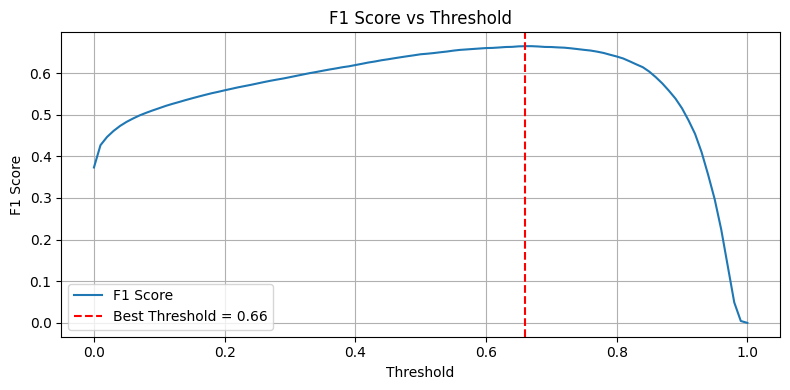

In [31]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Huấn luyện mô hình với scale_pos_weight
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    # scale_pos_weight=11.32,
    random_seed=42,
    verbose=0
)

cat_model.fit(X_sm, y_sm)

# Dự đoán xác suất
y_probs = cat_model.predict_proba(X_test)[:, 1]

import numpy as np
import matplotlib.pyplot as plt

thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_t = (y_probs >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_t))

# Tìm ngưỡng tốt nhất
best_thresh = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"Best Threshold: {best_thresh}, F1: {best_f1}")

# Vẽ biểu đồ
plt.figure(figsize=(8, 4))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.axvline(best_thresh, color='r', linestyle='--', label=f'Best Threshold = {best_thresh:.2f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

THRESHOLD = best_thresh
# SCALE_POS_WEIGHT = 11.32

def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 500),
        "depth": trial.suggest_int("depth", 4, 8),  
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15),  # Giảm rate
        "random_seed": 42,
        "verbose": 0,
    }

    model = CatBoostClassifier(**params)
    model.fit(X_sm, y_sm)

    # Dự đoán xác suất và áp dụng threshold
    y_probs = model.predict_proba(X_test)[:, 1]
    y_pred = (y_probs >= THRESHOLD).astype(int)

    # Đánh giá bằng F1-score cho lớp mất cân bằng
    score = f1_score(y_test, y_pred)
    return score

# Tạo và chạy study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# In kết quả tốt nhất
print("Best trial:")
print(study.best_trial)
print("Best F1 Score:", study.best_value)
print("Best hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")

# Huấn luyện lại với tham số tốt nhất
best_params = study.best_trial.params
best_params.update({
    # 'scale_pos_weight': SCALE_POS_WEIGHT,
    'random_seed': 42,
    'verbose': 0
})

best_model = CatBoostClassifier(**best_params)
best_model.fit(X_sm, y_sm)

# Dự đoán với threshold 
y_probs = best_model.predict_proba(X_test)[:, 1]
y_pred_thresh = (y_probs >= THRESHOLD).astype(int)

# In kết quả
from sklearn.metrics import classification_report
print(f"\nClassification report with threshold = {THRESHOLD}:")
print(classification_report(y_test, y_pred_thresh))

[I 2025-05-04 04:58:12,827] A new study created in memory with name: no-name-a70fa6d4-9a55-4755-b16b-08e7e94942f6
[I 2025-05-04 04:59:06,314] Trial 0 finished with value: 0.6321805232906892 and parameters: {'iterations': 495, 'depth': 7, 'learning_rate': 0.09934855351813962}. Best is trial 0 with value: 0.6321805232906892.
[I 2025-05-04 04:59:34,508] Trial 1 finished with value: 0.6711536101645317 and parameters: {'iterations': 316, 'depth': 5, 'learning_rate': 0.07420765617455652}. Best is trial 1 with value: 0.6711536101645317.
[I 2025-05-04 05:00:07,962] Trial 2 finished with value: 0.6471459121566047 and parameters: {'iterations': 437, 'depth': 4, 'learning_rate': 0.024004158533873953}. Best is trial 1 with value: 0.6711536101645317.
[I 2025-05-04 05:00:37,801] Trial 3 finished with value: 0.6807595914768844 and parameters: {'iterations': 276, 'depth': 7, 'learning_rate': 0.09874490037952496}. Best is trial 3 with value: 0.6807595914768844.
[I 2025-05-04 05:01:10,871] Trial 4 finis

Best trial:
FrozenTrial(number=7, state=1, values=[0.6828613661117161], datetime_start=datetime.datetime(2025, 5, 4, 5, 2, 20, 863325), datetime_complete=datetime.datetime(2025, 5, 4, 5, 2, 52, 869008), params={'iterations': 366, 'depth': 5, 'learning_rate': 0.11469705490328422}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=500, log=False, low=100, step=1), 'depth': IntDistribution(high=8, log=False, low=4, step=1), 'learning_rate': FloatDistribution(high=0.15, log=False, low=0.01, step=None)}, trial_id=7, value=None)
Best F1 Score: 0.6828613661117161
Best hyperparameters:
iterations: 366
depth: 5
learning_rate: 0.11469705490328422

Classification report with threshold = 0.66:
              precision    recall  f1-score   support

           0       0.92      0.87      0.90    159566
           1       0.63      0.74      0.68     47528

    accuracy                           0.84    207094
   macro avg       0.78      0.81  

In [33]:
# from sklearn.metrics import (
#     accuracy_score, precision_score, recall_score,
#     f1_score, classification_report, confusion_matrix
# )
# # Tạo mô hình với tham số đã tối ưu
# catboost_model = CatBoostClassifier(
#     iterations=395,
#     depth=4,
#     learning_rate=0.10643275132479328,
#     # scale_pos_weight=11.32,
#     random_seed=42,
#     verbose=0
# )

# # Huấn luyện mô hình
# catboost_model.fit(X_sm, y_sm)

# # Dự đoán xác suất
# y_probs = catboost_model.predict_proba(X_test)[:, 1]

# # Áp dụng threshold
# THRESHOLD = 0.7
# y_pred = (y_probs >= THRESHOLD).astype(int)

# # Đánh giá mô hình
# acc = accuracy_score(y_test, y_pred)
# prec = precision_score(y_test, y_pred)
# rec = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

# print("Threshold:", THRESHOLD)
# print("Accuracy :", acc)
# print("Precision:", prec)
# print("Recall   :", rec)
# print("F1 Score :", f1)
# print("\nClassification Report:\n", classification_report(y_test, y_pred))

# # Confusion Matrix
# cm = confusion_matrix(y_test, y_pred)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title(f'Confusion Matrix - CatBoost (Threshold = {THRESHOLD})')
# plt.show()

### 5.2.3 SMOTE ENN

In [34]:
# SMOTE ENN
from imblearn.combine import SMOTEENN

smenn = SMOTEENN()

X_smenn, y_smenn = smenn.fit_resample(X_train, y_train)
X_smenn.shape, y_sm.shape

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_smenn)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [35]:
from catboost import CatBoostClassifier

# Khởi tạo CatBoost model với xử lý mất cân bằng
cat_model = CatBoostClassifier()

# Train
cat_model.fit(X_smenn, y_smenn)

# Predict
y_pred = cat_model.predict(X_test)

print_scores(y_test, y_pred)

Learning rate set to 0.163006
0:	learn: 0.5780915	total: 79.5ms	remaining: 1m 19s
1:	learn: 0.5073575	total: 163ms	remaining: 1m 21s
2:	learn: 0.4584181	total: 242ms	remaining: 1m 20s
3:	learn: 0.4290730	total: 319ms	remaining: 1m 19s
4:	learn: 0.4069275	total: 397ms	remaining: 1m 19s
5:	learn: 0.3885293	total: 478ms	remaining: 1m 19s
6:	learn: 0.3752888	total: 550ms	remaining: 1m 18s
7:	learn: 0.3642411	total: 630ms	remaining: 1m 18s
8:	learn: 0.3554694	total: 707ms	remaining: 1m 17s
9:	learn: 0.3494669	total: 780ms	remaining: 1m 17s
10:	learn: 0.3436678	total: 857ms	remaining: 1m 17s
11:	learn: 0.3372453	total: 936ms	remaining: 1m 17s
12:	learn: 0.3322133	total: 1.01s	remaining: 1m 16s
13:	learn: 0.3277809	total: 1.09s	remaining: 1m 17s
14:	learn: 0.3239636	total: 1.17s	remaining: 1m 16s
15:	learn: 0.3206556	total: 1.24s	remaining: 1m 16s
16:	learn: 0.3181136	total: 1.31s	remaining: 1m 15s
17:	learn: 0.3127882	total: 1.4s	remaining: 1m 16s
18:	learn: 0.3105779	total: 1.48s	remaining:

In [36]:
from catboost import CatBoostClassifier

# Khởi tạo CatBoost model với xử lý mất cân bằng
cat_model = CatBoostClassifier()

# Train
cat_model.fit(X_train_scaled, y_smenn)

# Predict
y_pred = cat_model.predict(X_test_scaled)

print_scores(y_test, y_pred)

Learning rate set to 0.163006
0:	learn: 0.5780915	total: 78.9ms	remaining: 1m 18s
1:	learn: 0.5073575	total: 162ms	remaining: 1m 20s
2:	learn: 0.4584181	total: 239ms	remaining: 1m 19s
3:	learn: 0.4290730	total: 317ms	remaining: 1m 18s
4:	learn: 0.4069275	total: 394ms	remaining: 1m 18s
5:	learn: 0.3885293	total: 476ms	remaining: 1m 18s
6:	learn: 0.3752889	total: 553ms	remaining: 1m 18s
7:	learn: 0.3642402	total: 632ms	remaining: 1m 18s
8:	learn: 0.3553894	total: 710ms	remaining: 1m 18s
9:	learn: 0.3495422	total: 783ms	remaining: 1m 17s
10:	learn: 0.3425742	total: 863ms	remaining: 1m 17s
11:	learn: 0.3373625	total: 940ms	remaining: 1m 17s
12:	learn: 0.3320517	total: 1.01s	remaining: 1m 16s
13:	learn: 0.3272766	total: 1.09s	remaining: 1m 16s
14:	learn: 0.3235160	total: 1.16s	remaining: 1m 16s
15:	learn: 0.3204464	total: 1.24s	remaining: 1m 16s
16:	learn: 0.3179812	total: 1.31s	remaining: 1m 15s
17:	learn: 0.3151014	total: 1.39s	remaining: 1m 16s
18:	learn: 0.3114294	total: 1.47s	remaining

In [37]:
from catboost import CatBoostClassifier

# Khởi tạo CatBoost model với xử lý mất cân bằng
cat_model = CatBoostClassifier()

# Train
cat_model.fit(X_train_scaled[top_features], y_smenn)

# Predict
y_pred = cat_model.predict(X_test_scaled[top_features])

print_scores(y_test, y_pred)

Learning rate set to 0.163006
0:	learn: 0.5887135	total: 63.3ms	remaining: 1m 3s
1:	learn: 0.5160142	total: 129ms	remaining: 1m 4s
2:	learn: 0.4693022	total: 194ms	remaining: 1m 4s
3:	learn: 0.4321594	total: 256ms	remaining: 1m 3s
4:	learn: 0.4078961	total: 320ms	remaining: 1m 3s
5:	learn: 0.3927216	total: 387ms	remaining: 1m 4s
6:	learn: 0.3793572	total: 453ms	remaining: 1m 4s
7:	learn: 0.3700282	total: 516ms	remaining: 1m 3s
8:	learn: 0.3602185	total: 578ms	remaining: 1m 3s
9:	learn: 0.3526612	total: 639ms	remaining: 1m 3s
10:	learn: 0.3476735	total: 703ms	remaining: 1m 3s
11:	learn: 0.3421426	total: 768ms	remaining: 1m 3s
12:	learn: 0.3380771	total: 830ms	remaining: 1m 3s
13:	learn: 0.3341248	total: 889ms	remaining: 1m 2s
14:	learn: 0.3307668	total: 948ms	remaining: 1m 2s
15:	learn: 0.3270865	total: 1.01s	remaining: 1m 2s
16:	learn: 0.3248433	total: 1.07s	remaining: 1m 1s
17:	learn: 0.3198195	total: 1.14s	remaining: 1m 2s
18:	learn: 0.3176710	total: 1.2s	remaining: 1m 1s
19:	learn: 

=> Không chọn đặc trưng, scale cũng có cải thiện.

In [38]:
from catboost import CatBoostClassifier

# Khởi tạo CatBoost model với xử lý mất cân bằng
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    # scale_pos_weight=11.32,     # tương đương XGBoost
    random_seed=42,
    verbose=0               # tắt output training
)

# Train
cat_model.fit(X_smenn, y_smenn)

# Predict
y_pred = cat_model.predict(X_test)

print_scores(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.96      0.72      0.82    159566
           1       0.49      0.90      0.63     47528

    accuracy                           0.76    207094
   macro avg       0.72      0.81      0.73    207094
weighted avg       0.85      0.76      0.78    207094



In [39]:
from catboost import CatBoostClassifier

# Khởi tạo CatBoost model với xử lý mất cân bằng
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    scale_pos_weight=11.32,     # tương đương XGBoost
    random_seed=42,
    verbose=0               # tắt output training
)

# Train
cat_model.fit(X_smenn, y_smenn)

# Predict
y_pred = cat_model.predict(X_test)

print_scores(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.98      0.48      0.65    159566
           1       0.36      0.97      0.52     47528

    accuracy                           0.60    207094
   macro avg       0.67      0.73      0.59    207094
weighted avg       0.84      0.60      0.62    207094



=> Không dùng scale_pos_weight

In [40]:
from catboost import CatBoostClassifier

# Khởi tạo CatBoost model với xử lý mất cân bằng
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    # scale_pos_weight=11.32,     # tương đương XGBoost
    random_seed=42,
    verbose=0               # tắt output training
)

# Train
cat_model.fit(X_train_scaled, y_smenn)

# Predict
y_pred = cat_model.predict(X_test_scaled)

print_scores(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.96      0.72      0.82    159566
           1       0.49      0.89      0.63     47528

    accuracy                           0.76    207094
   macro avg       0.72      0.81      0.73    207094
weighted avg       0.85      0.76      0.78    207094



=> Dùng scale hay không đều được

In [41]:
from catboost import CatBoostClassifier

# Khởi tạo CatBoost model với xử lý mất cân bằng
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    # scale_pos_weight=11.32,     # tương đương XGBoost
    random_seed=42,
    verbose=0               # tắt output training
)

# Train
cat_model.fit(X_train_scaled[top_features], y_smenn)

# Predict
y_pred = cat_model.predict(X_test_scaled[top_features])

print_scores(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.96      0.68      0.80    159566
           1       0.46      0.91      0.61     47528

    accuracy                           0.73    207094
   macro avg       0.71      0.79      0.70    207094
weighted avg       0.85      0.73      0.75    207094



**Tuning CatBoost chỉ SMOTE ENN với Optuna**

Best Threshold: 0.78, Best F1 Score : 0.6753182170283167


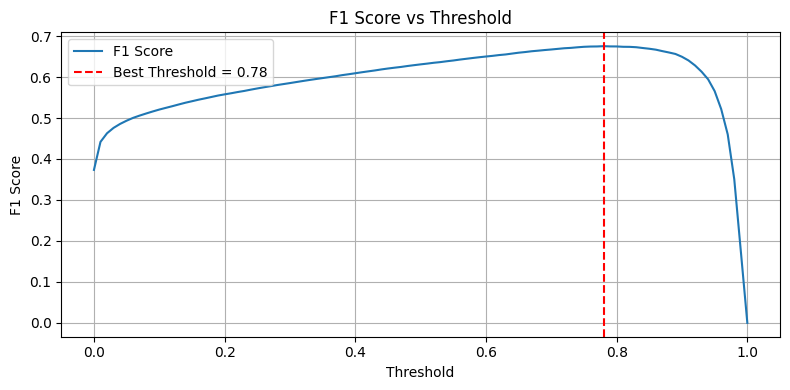

In [42]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Huấn luyện mô hình với scale_pos_weight
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    # scale_pos_weight=11.32,
    random_seed=42,
    verbose=0
)

cat_model.fit(X_smenn, y_smenn)

# Dự đoán xác suất
y_probs = cat_model.predict_proba(X_test)[:, 1]

import numpy as np
import matplotlib.pyplot as plt

thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_t = (y_probs >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_t))

# Tìm ngưỡng tốt nhất
best_thresh = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"Best Threshold: {best_thresh}, Best F1 Score : {best_f1}")

# Vẽ biểu đồ
plt.figure(figsize=(8, 4))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.axvline(best_thresh, color='r', linestyle='--', label=f'Best Threshold = {best_thresh:.2f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [43]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

THRESHOLD = best_thresh
# SCALE_POS_WEIGHT = 11.32

def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 500),
        "depth": trial.suggest_int("depth", 4, 8),  # Đừng quá cao
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15),  # Giảm rate
        "random_seed": 42,
        "verbose": 0,
    }

    model = CatBoostClassifier(**params)
    model.fit(X_smenn, y_smenn)

    # Dự đoán xác suất và áp dụng threshold
    y_probs = model.predict_proba(X_test)[:, 1]
    y_pred = (y_probs >= THRESHOLD).astype(int)

    # Đánh giá bằng F1-score cho lớp mất cân bằng
    score = f1_score(y_test, y_pred)
    return score

# Tạo và chạy study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# In kết quả tốt nhất
print("Best trial:")
print(study.best_trial)
print("Best F1 Score:", study.best_value)
print("Best hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")

# Huấn luyện lại với tham số tốt nhất
best_params = study.best_trial.params
best_params.update({
    # 'scale_pos_weight': SCALE_POS_WEIGHT,
    'random_seed': 42,
    'verbose': 0
})

best_model = CatBoostClassifier(**best_params)
best_model.fit(X_smenn, y_smenn)

# Dự đoán với threshold 
y_probs = best_model.predict_proba(X_test)[:, 1]
y_pred_thresh = (y_probs >= THRESHOLD).astype(int)

# In kết quả
from sklearn.metrics import classification_report
print(f"\nClassification report with threshold = {THRESHOLD}:")
print(classification_report(y_test, y_pred_thresh))

[I 2025-05-04 05:41:40,730] A new study created in memory with name: no-name-a7a3faf9-ad99-40eb-8942-5864f7f871a4
[I 2025-05-04 05:42:06,496] Trial 0 finished with value: 0.6835964176308755 and parameters: {'iterations': 349, 'depth': 5, 'learning_rate': 0.0766838174472501}. Best is trial 0 with value: 0.6835964176308755.
[I 2025-05-04 05:42:55,949] Trial 1 finished with value: 0.6731501947163457 and parameters: {'iterations': 480, 'depth': 8, 'learning_rate': 0.07699826785597703}. Best is trial 0 with value: 0.6835964176308755.
[I 2025-05-04 05:43:14,548] Trial 2 finished with value: 0.6808568068328609 and parameters: {'iterations': 289, 'depth': 4, 'learning_rate': 0.13045728392270386}. Best is trial 0 with value: 0.6835964176308755.
[I 2025-05-04 05:43:49,743] Trial 3 finished with value: 0.6520465388800535 and parameters: {'iterations': 394, 'depth': 7, 'learning_rate': 0.14556935588194467}. Best is trial 0 with value: 0.6835964176308755.
[I 2025-05-04 05:44:33,223] Trial 4 finishe

Best trial:
FrozenTrial(number=12, state=1, values=[0.6913441351668993], datetime_start=datetime.datetime(2025, 5, 4, 5, 47, 24, 323260), datetime_complete=datetime.datetime(2025, 5, 4, 5, 47, 58, 249919), params={'iterations': 470, 'depth': 5, 'learning_rate': 0.09957079477214217}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=500, log=False, low=100, step=1), 'depth': IntDistribution(high=8, log=False, low=4, step=1), 'learning_rate': FloatDistribution(high=0.15, log=False, low=0.01, step=None)}, trial_id=12, value=None)
Best F1 Score: 0.6913441351668993
Best hyperparameters:
iterations: 470
depth: 5
learning_rate: 0.09957079477214217

Classification report with threshold = 0.78:
              precision    recall  f1-score   support

           0       0.92      0.89      0.90    159566
           1       0.66      0.72      0.69     47528

    accuracy                           0.85    207094
   macro avg       0.79      0.

In [44]:
# from sklearn.metrics import (
#     accuracy_score, precision_score, recall_score,
#     f1_score, classification_report, confusion_matrix
# )
# # Tạo mô hình với tham số đã tối ưu
# catboost_model = CatBoostClassifier(
#     iterations=434,
#     depth=6,
#     learning_rate=0.097919302671831,
#     # scale_pos_weight=11.32,
#     random_seed=42,
#     verbose=0
# )

# # Huấn luyện mô hình
# catboost_model.fit(X_smenn, y_smenn)

# # Dự đoán xác suất
# y_probs = catboost_model.predict_proba(X_test)[:, 1]

# # Áp dụng threshold
# THRESHOLD = 0.77
# y_pred = (y_probs >= THRESHOLD).astype(int)

# # Đánh giá mô hình
# acc = accuracy_score(y_test, y_pred)
# prec = precision_score(y_test, y_pred)
# rec = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

# print("Threshold:", THRESHOLD)
# print("Accuracy :", acc)
# print("Precision:", prec)
# print("Recall   :", rec)
# print("F1 Score :", f1)
# print("\nClassification Report:\n", classification_report(y_test, y_pred))

# # Confusion Matrix
# cm = confusion_matrix(y_test, y_pred)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title(f'Confusion Matrix - CatBoost (Threshold = {THRESHOLD})')
# plt.show()

**Tuning CatBoost SMOTE ENN và đã chuẩn hóa với Optuna**

Best Threshold: 0.8, Best F1 Score : 0.6735003796507212


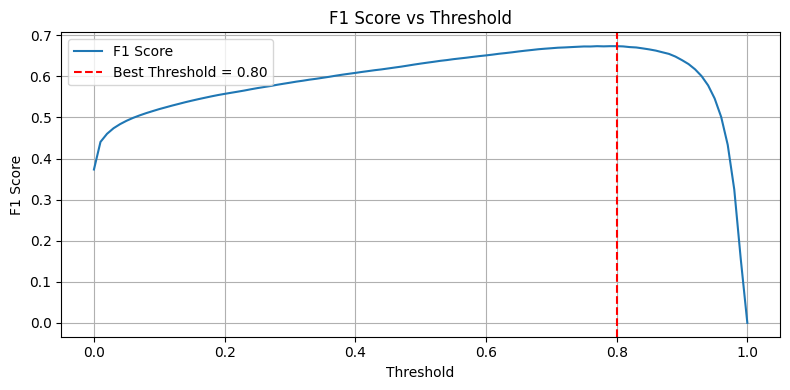

In [45]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Huấn luyện mô hình với scale_pos_weight
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    # scale_pos_weight=11.32,
    random_seed=42,
    verbose=0
)

cat_model.fit(X_train_scaled, y_smenn)

# Dự đoán xác suất
y_probs = cat_model.predict_proba(X_test_scaled)[:, 1]

import numpy as np
import matplotlib.pyplot as plt

thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_t = (y_probs >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_t))

# Tìm ngưỡng tốt nhất
best_thresh = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"Best Threshold: {best_thresh}, Best F1 Score : {best_f1}")

# Vẽ biểu đồ
plt.figure(figsize=(8, 4))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.axvline(best_thresh, color='r', linestyle='--', label=f'Best Threshold = {best_thresh:.2f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [46]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

THRESHOLD = best_thresh
# SCALE_POS_WEIGHT = 11.32

def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 500),
        "depth": trial.suggest_int("depth", 4, 8),  # Đừng quá cao
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15),  # Giảm rate
        "random_seed": 42,
        "verbose": 0,
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train_scaled, y_smenn)

    # Dự đoán xác suất và áp dụng threshold
    y_probs = model.predict_proba(X_test_scaled)[:, 1]
    y_pred = (y_probs >= THRESHOLD).astype(int)

    # Đánh giá bằng F1-score cho lớp mất cân bằng
    score = f1_score(y_test, y_pred)
    return score

# Tạo và chạy study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# In kết quả tốt nhất
print("Best trial:")
print(study.best_trial)
print("Best F1 Score:", study.best_value)
print("Best hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")

# Huấn luyện lại với tham số tốt nhất
best_params = study.best_trial.params
best_params.update({
    # 'scale_pos_weight': SCALE_POS_WEIGHT,
    'random_seed': 42,
    'verbose': 0
})

best_model = CatBoostClassifier(**best_params)
best_model.fit(X_train_scaled, y_smenn)

# Dự đoán với threshold 
y_probs = best_model.predict_proba(X_test_scaled)[:, 1]
y_pred_thresh = (y_probs >= THRESHOLD).astype(int)

# In kết quả
from sklearn.metrics import classification_report
print(f"\nClassification report with threshold = {THRESHOLD}:")
print(classification_report(y_test, y_pred_thresh))

[I 2025-05-04 05:56:23,792] A new study created in memory with name: no-name-69d08bcc-5f87-4cde-9c4d-e3bd1845bc7b
[I 2025-05-04 05:56:32,583] Trial 0 finished with value: 0.6681705705228219 and parameters: {'iterations': 118, 'depth': 5, 'learning_rate': 0.14993136804311702}. Best is trial 0 with value: 0.6681705705228219.
[I 2025-05-04 05:56:52,259] Trial 1 finished with value: 0.6520093435667637 and parameters: {'iterations': 238, 'depth': 6, 'learning_rate': 0.017524064917633773}. Best is trial 0 with value: 0.6681705705228219.
[I 2025-05-04 05:57:07,215] Trial 2 finished with value: 0.6642528370764225 and parameters: {'iterations': 231, 'depth': 4, 'learning_rate': 0.12202757431507746}. Best is trial 0 with value: 0.6681705705228219.
[I 2025-05-04 05:57:38,894] Trial 3 finished with value: 0.6602598013283959 and parameters: {'iterations': 392, 'depth': 6, 'learning_rate': 0.02561164213359111}. Best is trial 0 with value: 0.6681705705228219.
[I 2025-05-04 05:58:01,438] Trial 4 finis

Best trial:
FrozenTrial(number=27, state=1, values=[0.6908815814035743], datetime_start=datetime.datetime(2025, 5, 4, 6, 8, 58, 280526), datetime_complete=datetime.datetime(2025, 5, 4, 6, 9, 28, 882538), params={'iterations': 471, 'depth': 4, 'learning_rate': 0.11041681098791521}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=500, log=False, low=100, step=1), 'depth': IntDistribution(high=8, log=False, low=4, step=1), 'learning_rate': FloatDistribution(high=0.15, log=False, low=0.01, step=None)}, trial_id=27, value=None)
Best F1 Score: 0.6908815814035743
Best hyperparameters:
iterations: 471
depth: 4
learning_rate: 0.11041681098791521

Classification report with threshold = 0.8:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90    159566
           1       0.65      0.74      0.69     47528

    accuracy                           0.85    207094
   macro avg       0.78      0.81 

In [47]:
# from sklearn.metrics import (
#     accuracy_score, precision_score, recall_score,
#     f1_score, classification_report, confusion_matrix
# )
# # Tạo mô hình với tham số đã tối ưu
# catboost_model = CatBoostClassifier(
#     iterations=452,
#     depth=4,
#     learning_rate=0.12655128193358028,
#     # scale_pos_weight=11.32,
#     random_seed=42,
#     verbose=0
# )

# # Huấn luyện mô hình
# catboost_model.fit(X_train_scaled, y_smenn)

# # Dự đoán xác suất
# y_probs = catboost_model.predict_proba(X_test_scaled)[:, 1]

# # Áp dụng threshold
# THRESHOLD = 0.76
# y_pred = (y_probs >= THRESHOLD).astype(int)

# # Đánh giá mô hình
# acc = accuracy_score(y_test, y_pred)
# prec = precision_score(y_test, y_pred)
# rec = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

# print("Threshold:", THRESHOLD)
# print("Accuracy :", acc)
# print("Precision:", prec)
# print("Recall   :", rec)
# print("F1 Score :", f1)
# print("\nClassification Report:\n", classification_report(y_test, y_pred))

# # Confusion Matrix
# cm = confusion_matrix(y_test, y_pred)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title(f'Confusion Matrix - CatBoost (Threshold = {THRESHOLD})')
# plt.show()

# 7. Kết luận

* Nếu **muốn mô hình ổn định, đơn giản, không xử lý dữ liệu phức tạp** → **Chọn mô hình gốc dùng `scale_pos_weight`**
* Nếu **ưu tiên recall cao nhất (bắt hết mưa)**, chấp nhận nhiều cảnh báo giả → **Chọn mô hình SMOTEENN + chuẩn hóa**
* Nếu **ưu tiên precision cao (giảm cảnh báo giả)**, chấp nhận một số mưa bị bỏ sót → **Chọn mô hình SMOTE**

Cả 3 mô hình có f1 bằng nhau.